In [1]:
from __future__ import division
%matplotlib inline
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
from model_fit import *
import seaborn as sb

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
model = 'gaussian'

In [3]:
frqs, T_sky ,sigma = np.loadtxt('dataset8.txt', unpack = True)

Los valores reales de los parametros son:

In [4]:
reals=[100., 80.,10., 7.5, -2.55, 0.1]

In [5]:
#frqs, T_sky = np.loadtxt('scihi_fore.txt', unpack=True)

In [6]:
#sigma = radiometer(T_sky, 0.83, np.diff(frqs)[0])

In [7]:
sb.set_style("white")

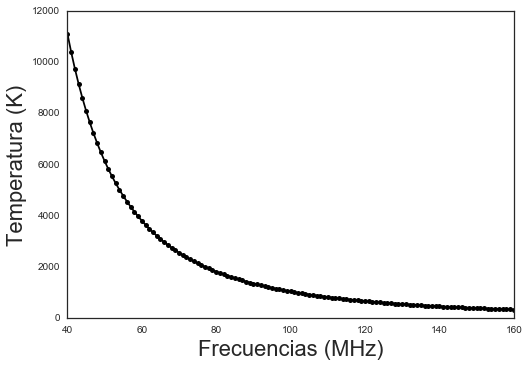

In [54]:
fig = plt.figure()
plt.errorbar(frqs,T_sky,yerr = sigma,c='k',marker='o',ms=5, )
plt.xlabel('Frecuencias (MHz)', fontsize=22)
plt.ylabel('Temperatura (K)',fontsize=22)
fig.savefig('tempg.pdf')

In [10]:
print max(frqs), min(frqs)

160.0 40.0


In [11]:
priors_gauss = np.array([0.,1000., min(frqs),max(frqs), 0.,40., 0.,10., -10.,0., -1.,1.])

In [12]:
ndim = int(np.size(priors_gauss)/2)

In [13]:
print ndim

6


In [14]:
mid = np.zeros(ndim)

In [15]:
for i in range(ndim):
    mid[i] = priors_gauss[2*i] + priors_gauss[2*i + 1]

In [16]:
mid = 0.5 * mid

In [17]:
fun = lambda *args: -lnhood(*args)

In [18]:
result = op.minimize(fun, mid, args=(model, T_sky, frqs, sigma), method = 'L-BFGS-B')

In [19]:
print result.x

[  4.96974079e+02   4.61359482e+01   2.78220898e+01   7.50008337e+00
  -2.55006234e+00   9.98692369e-02]


In [20]:
round(result.x[5],3)

0.1

In [24]:
fore = foreground(frqs)
T_gx2 = fore(round(result.x[3],3),round(result.x[4],3),round(result.x[5],3))
T_gx = fore(8.13, -2.36, -0.1)

In [29]:
t_b = (T_sky - T_gx) * 1000.
t_b2 = (T_sky - T_gx2)*1000.

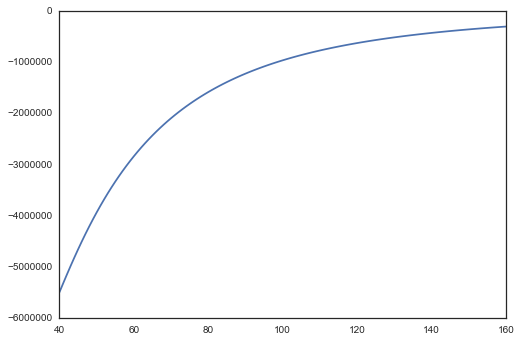

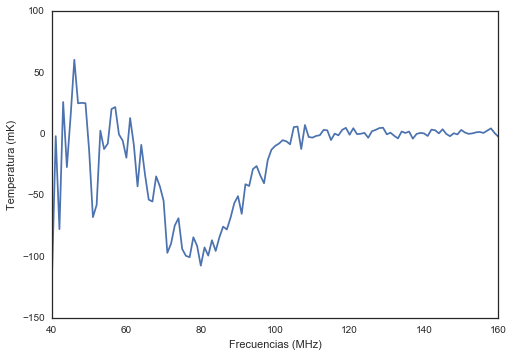

In [30]:
fig1=plt.figure()
plt.plot(frqs, t_b) 
#plt.title('Residuos')
#plt.xlabel('Frecuencias (MHz)')
#plt.ylabel('Temperatura (mK)')
#fig1.savefig('res_g1.pdf')
fig21=plt.figure()
plt.plot(frqs,t_b2)
plt.xlabel('Frecuencias (MHz)')
plt.ylabel('Temperatura (mK)')
#fig21.savefig('res_sci.pdf')

In [31]:
nwalkers = 200

In [32]:
z = np.zeros((ndim, nwalkers))

In [33]:
h = 1e-2

In [34]:
pos_i=[]

In [35]:
np.random.seed(0)

In [36]:
for i in range(ndim):
    z[i,:] = result.x[i] + h*np.random.randn(nwalkers)

In [37]:
for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i],z[3,i],z[4,i],z[5,i]]))

In [38]:
b_steps,  steps = 500, 1000

In [39]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(model, T_sky, frqs, sigma, priors_gauss,0.0))

In [40]:
pos, prob, state = sampler.run_mcmc(pos_i, b_steps)

In [41]:
sampler.reset()

In [42]:
_, _, _ = sampler.run_mcmc(pos, steps, rstate0=state)

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


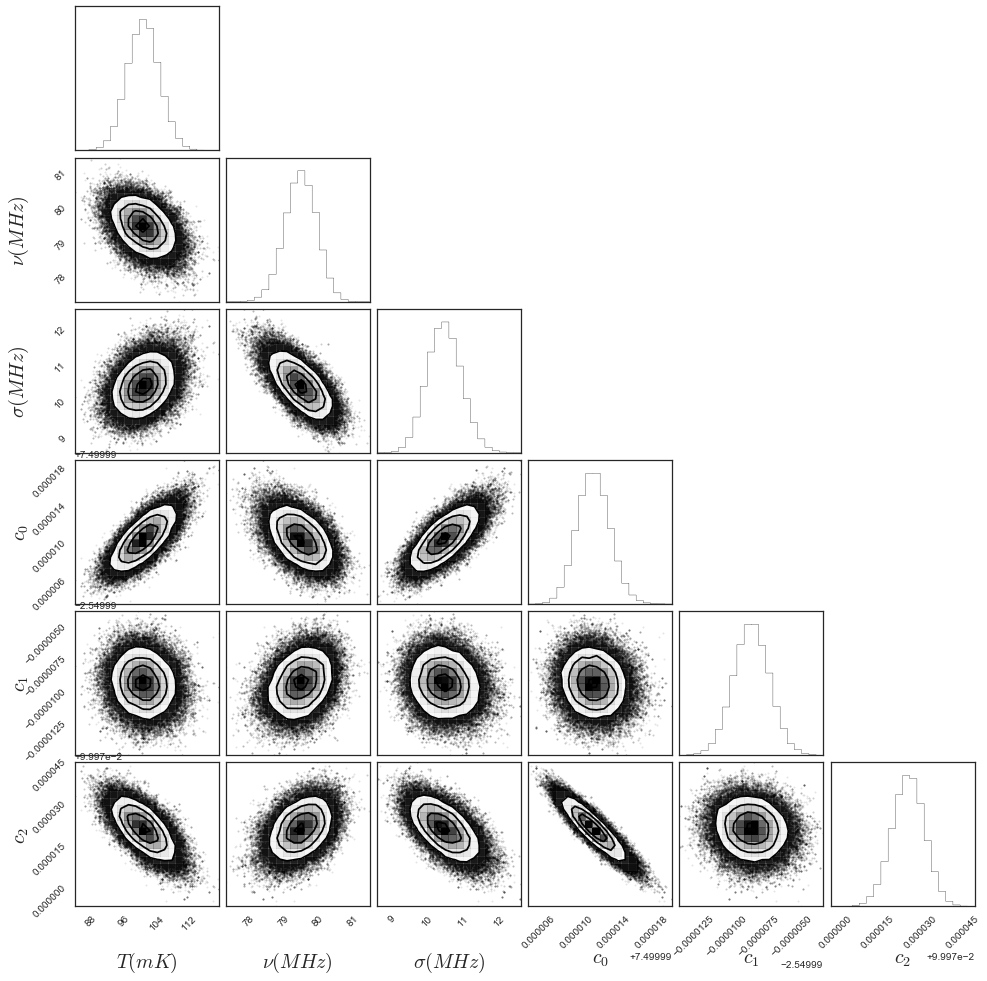

In [43]:
fig = corner.corner(sampler.flatchain, labels = ['$T (mK)$',r'$\nu (MHz)$',r'$\sigma (MHz)$',r'$c_0$',r'$c_1$',r'$c_2$'] ,label_kwargs={'fontsize': 20});

In [ ]:
#fig.savefig('mcmc_sci_plot.pdf')

In [ ]:
#np.savetxt('mcmc_sci_plot.txt', sampler.flatchain)

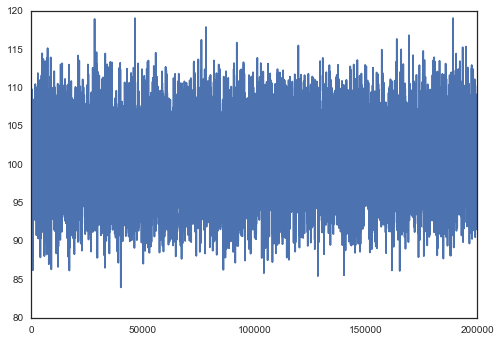

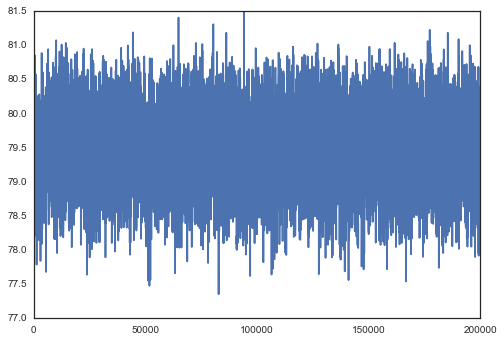

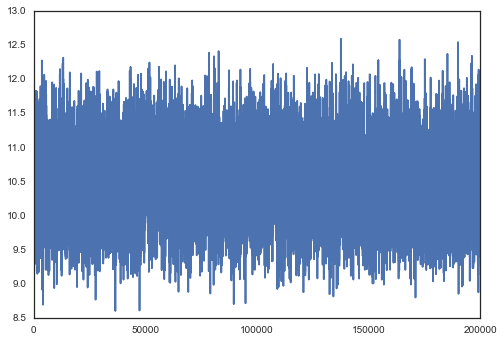

In [44]:
plt.figure()
plt.plot(sampler.flatchain[:,0])
plt.figure()
plt.plot(sampler.flatchain[:,1])
plt.figure()
plt.plot(sampler.flatchain[:,2])

In [45]:
t_corr = np.zeros((nwalkers,steps))                
nu_corr = np.zeros((nwalkers,steps)) 
s_corr = np.zeros((nwalkers,steps)) 

In [46]:
for i in range(nwalkers):
    t_corr[i] = emcee.autocorr.function(sampler.chain[i,:,0],axis=0)
    nu_corr[i] = emcee.autocorr.function(sampler.chain[i,:,1],axis=0)
    s_corr[i] = emcee.autocorr.function(sampler.chain[i,:,2],axis=0)

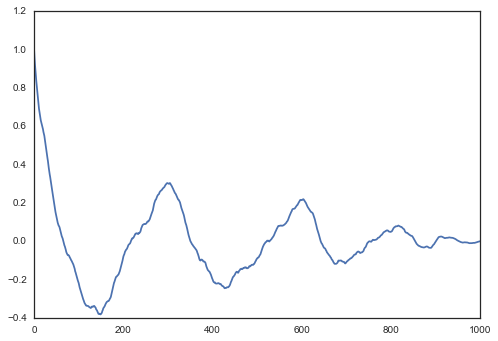

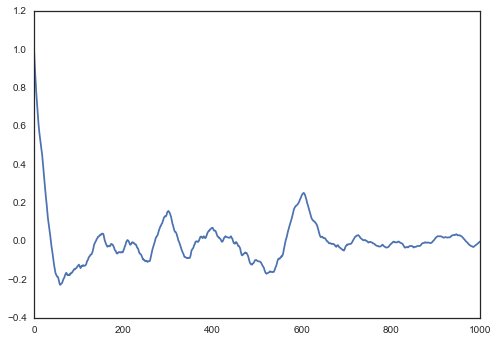

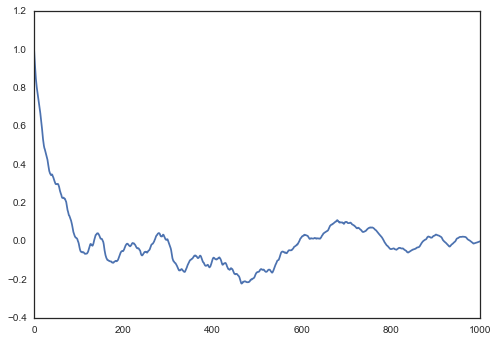

In [47]:
number = 60
plt.figure()
plt.plot(t_corr[number][:])
plt.figure()
plt.plot(nu_corr[number][:])
plt.figure()
plt.plot(s_corr[number][:])

In [ ]:
#sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(model, T_sky, frqs, sigma, priors_gauss,0.0))

In [ ]:
#sampler2.run_mcmc(pos_i, steps);

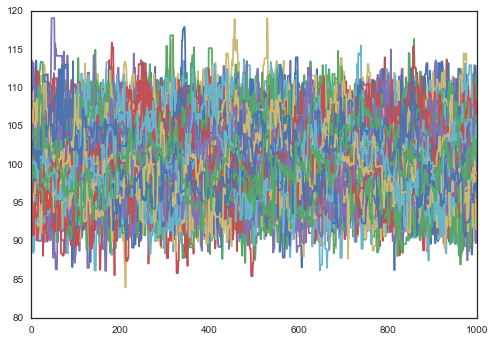

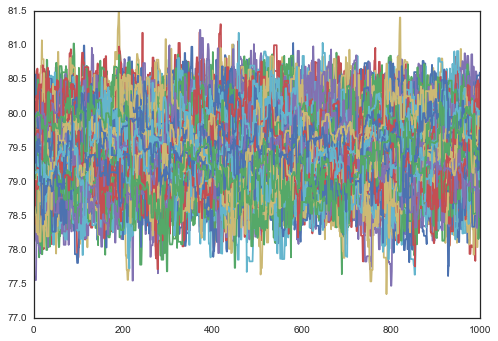

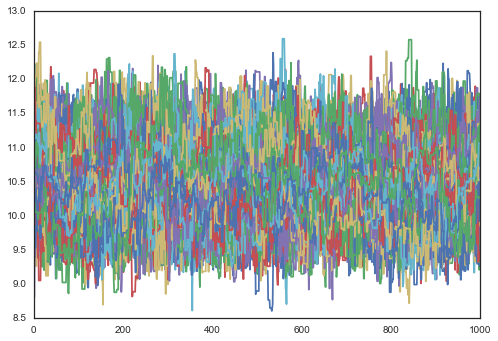

In [48]:
plt.figure()
plt.plot(sampler.chain[:,:,0].T);
plt.figure()
plt.plot(sampler.chain[:,:,1].T);
plt.figure()
plt.plot(sampler.chain[:,:,2].T);

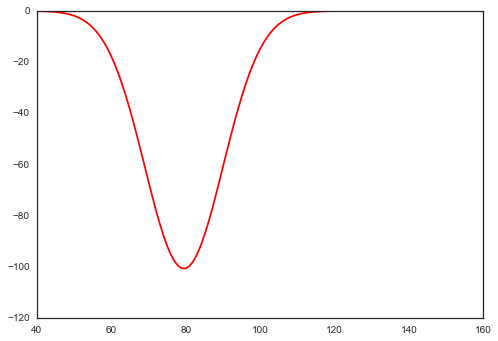

In [49]:
signal = model_21cm(frqs, model)
mean_t = np.mean(sampler.flatchain[:,0])
mean_n = np.mean(sampler.flatchain[:,1])
mean_s = np.mean(sampler.flatchain[:,2])
plt.plot(frqs, signal(mean_t, mean_n, mean_s), 'r')

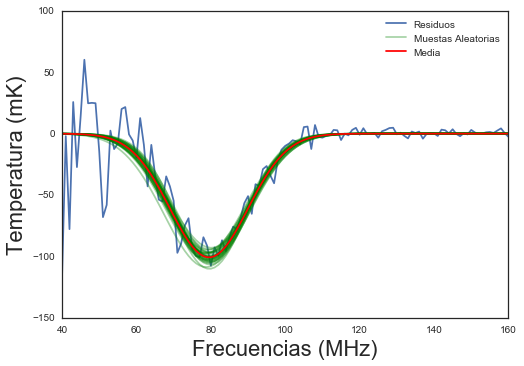

In [53]:

fig2 = plt.figure()
fg1, = plt.plot(frqs,t_b2)
#plt.plot(frqs, signal(100., 80.,10.), 'k')
for t, n, s, c1,c2,c3 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=30)]:
    fg2,=plt.plot(frqs,signal(t,n,s),'g', alpha=0.35)

mean_t = np.mean(sampler.flatchain[:,0])
mean_n = np.mean(sampler.flatchain[:,1])
mean_s = np.mean(sampler.flatchain[:,2])
#mean_c1 = np.mean(sampler.flatchain[:,3])
#mean_c2 = np.mean(sampler.flatchain[:,4])
#mean_c3 = np.mean(sampler.flatchain[:,5])

fg3,=plt.plot(frqs, signal(mean_t, mean_n, mean_s), 'r')
#fg4, = plt.plot(frqs, (T_sky-fore(mean_c1, mean_c2, mean_c3))*1000.,'k')
plt.legend([fg1,fg2,fg3],['Residuos','Muestas Aleatorias', 'Media'],loc='best')
plt.xlabel('Frecuencias (MHz)',fontsize=22)
plt.ylabel('Temperatura (mK)',fontsize=22)
fig2.savefig('samples_g.pdf')
